In [1]:
import os
import numpy as np
import json

data_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/"
label_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/"
label_file = "labels.json"
with open(os.path.join(label_dir, label_file), 'r') as f:
    labels = json.load(f)
print(labels[0])

{'id': 2000, 'mrn': 7962, 'eFI': 0.355899471, 'Three Categories': 'Frail', 'Two Categories': 'Abnormal', 'gender': 'Male', 'age': 79.0}


In [2]:
age_list = []
for i in range(len(labels)):
    age_list.append(labels[i]['age'])
age = np.array(age_list)

print("age mean: ", np.mean(age))
print("age std: ", np.std(age))

age mean:  67.89390519187359
age std:  8.095370237779274


In [5]:
import torch
import torch.nn as nn
from models.ResNet50 import Backbone
from models.Classifier import Classifier

backbone = Backbone()
classifier = Classifier(num_class=1)
model = nn.Sequential(backbone, classifier)
model.load_state_dict(torch.load("./model_save/best_metric_model_regression_resnet50.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Flipd,
    RandAffined,
    ToTensord,
    RepeatChanneld,
)
from monai.data import CacheDataset, DataLoader, Dataset, DistributedSampler, SmartCacheDataset, load_decathlon_datalist
# import matplotlib.pyplot as plt
from PIL import Image

data_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/original/"
label_dir = "/isilon/datalake/cialab/original/cialab/image_database/d00143/2022_dataset/"
label_file = "labels.json"
with open(os.path.join(label_dir, label_file), 'r') as f:
    labels = json.load(f)

# get the image file names and labels
image_name_list = [os.path.join(data_dir, str(image_name['id'])+'.nii') for image_name in labels]
map_three_categories = {'Frail': 0, 'Prefrail': 1, 'Not frail': 2,}
map_two_categories = {'Abnormal': 0, 'Normal': 1}
map_gender = {'Male': 0, 'Female': 1}

label_list = [[
                label['eFI'], 
                map_three_categories[label['Three Categories']], 
                map_two_categories[label['Two Categories']], 
                map_gender[label['gender']],
                label['age']
            ] for label in labels]
max_age = max([label[4] for label in label_list])
min_age = min([label[4] for label in label_list])
label_list = [[label[0], label[1], label[2], label[3], (label[4]-min_age)/(max_age-min_age)] for label in label_list]

# set the training and validation split
data_dicts = []
for image_name, label in zip(image_name_list, label_list):
    if os.path.exists(image_name):
        data_dicts.append({"image": image_name, "label": label})
train_files, val_files = data_dicts[:-94], data_dicts[-94:]

train_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-500,
            a_max=1500, 
            b_min=0.0, 
            b_max=1.0, 
            clip=True,
        ),
        RepeatChanneld(keys=["image"],repeats=3),
        ToTensord(keys=["image", "label"]),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(96, 96),
        #     pos=1,
        #     neg=1,
        #     num_samples=4,
        #     image_key="image",
        #     image_threshold=0,
        # ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-500,
            a_max=1500,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        RepeatChanneld(keys=["image"],repeats=3),
        ToTensord(keys=["image", "label"]),
    ]
)
val_ds = Dataset(data=data_dicts, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, shuffle=False, drop_last=True)

In [8]:
import tqdm
# device = torch.device("cuda:0")
device = torch.device("cpu")
model.to(device)
model.eval()
pred_list = []
with torch.no_grad():
    for val_data in tqdm.tqdm(val_loader):
    # for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = model(val_inputs)
        pred_list.append(val_outputs.cpu().numpy())

100%|██████████| 862/862 [02:08<00:00,  6.73it/s]


In [9]:
age_list = []
for i in range(len(data_dicts)):
    age_list.append(data_dicts[i]['label'][4]*(max_age-min_age)+min_age)
age = np.array(age_list)

In [10]:
age_pred_list = [pred[0][0]*(max_age-min_age)+min_age for pred in pred_list]
age_pred = np.array(age_pred_list)
print(len(age_pred_list))

862


In [14]:
pred_error = age_pred - age
print("pred_error mean: ", np.mean(np.abs(pred_error)))
print("pred_error mean train: ", np.mean(np.abs(pred_error[:-94])))
print("pred_error mean test: ", np.mean(np.abs(pred_error[-94:])))
print("pred_error std: ", np.sqrt(np.sum(np.square(pred_error))/len(pred_error)))
print("pred_error max: ", np.max(np.abs(pred_error)))
print("pred_error min: ", np.min(np.abs(pred_error)))
print("std of age: ", np.std(age))


pred_error mean:  6.900901493125891
pred_error mean train:  7.006304653749491
pred_error mean test:  6.039735244626694
pred_error std:  8.68535576279569
pred_error max:  68.74318313598633
pred_error min:  0.017298966646194458
std of age:  8.048381447549488


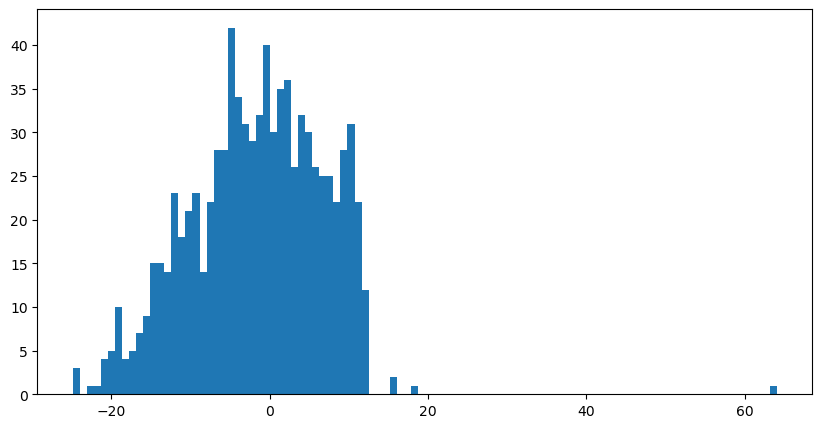

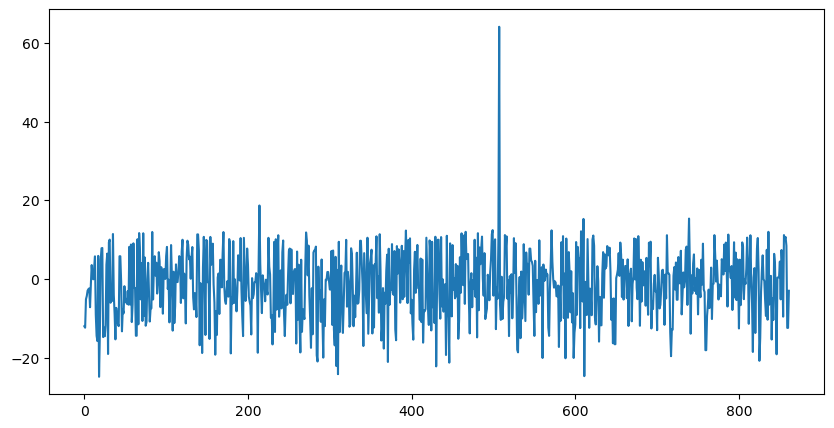

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(pred_error, bins=100)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pred_error)
plt.show()

In [31]:
print(min_age)
print(max_age)

55.0
94.0


In [2]:
import torch

cm = torch.load("./result/CM_train_epoch_40.pt")
print(cm)
cm = torch.load("./result/CM_test_epoch_50.pt")
print(cm)

tensor([[123.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 156.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0., 156.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1., 154.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1.,  82.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  64.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,  15.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.]])
tensor([[ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  5.,  0.,  3.,  0.,  0.,  0.,  0.],
        [ 3.,  0.,  4.,  1.,  1.,  1.,  0.,  0.],
        [ 3., 12.,  3., 14.,  0.,  3.,  0.,  3.],
        [ 8.,  2.,  8.,  0.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
